In [103]:
%matplotlib inline
import future
import pylab as plt
import numpy as np
from bornagain import target
from scipy.spatial import distance
from bornagain.simulate import refdata

In [104]:
from loki.utils.postproc_helper import is_outlier

def single_atom_dens(atomic_num, grid_size=3, grid_spacing=0.05,
                    filter_atomic_core=True, filter_thresh=50, 
                    filter_sig=5):
    """
    atomic_num, atomic number of element 
    grid_size, size of cubic density grid in Angstrom
    grid_spacing, spacing of cubic grid in Angstrom
    filter_atomic_core, whether to filter the faulty density at atomic core
    """
    #print atomic_num
    Ngrid_pt = int( float(grid_size)/grid_spacing)

    vals = np.arange( -Ngrid_pt/2, Ngrid_pt/2)  * grid_spacing #, grid_spacing)
    
    x,y,z = np.meshgrid( vals,vals,vals, sparse=True)
    R = np.sqrt( x**2 + y**2 + z**2 )
    R1 = R.ravel()

    rho = np.zeros( R1.shape).astype(np.float32)
    
    # this bit makes the form factor
    cromermann = refdata.get_cromermann_parameters( [atomic_num])[atomic_num]
    xo = 4.0 * (np.pi ** 2) * np.power( R1 , 2)
    for i in range(4):    
        rho += cromermann[i] * np.exp(-xo/cromermann[i+4])\
            / np.power(cromermann[i+4], 0.5 )
    
    rho *=  2 * np.sqrt(2) * np.pi

    if filter_atomic_core:
        dm = rho[ rho > 0].mean()
        s = rho [ rho > 0].std()

        idx = np.where( rho > dm+filter_sig*s)[0]
        vals = rho[ idx]
        bad = is_outlier( vals, filter_thresh)
        fillvalue = vals[~bad].max()
        bad_idx3 = idx[bad]
        rho[ bad_idx3] = fillvalue
        print ("Atom %d, replacing %d densities"%(atomic_num, sum(bad)))

    rho = rho.reshape( (Ngrid_pt, Ngrid_pt, Ngrid_pt))
    
    return rho


In [105]:
# make a plot of the atomic densities to test them
grid_param = {'grid_spacing':0.3,'grid_size':6, 
                'filter_thresh':1000, 
              'filter_sig':0, 'filter_atomic_core':True}

In [106]:
# this is the molecule loading
mol = target.crystal.Structure("2LYZ.pdb")
atom_vecs = mol.r*1e10
atomic_nums = mol.Z
atom_vecs -= atom_vecs.mean(0)

unique_atoms = np.unique(atomic_nums )
unique_atom_dens = {n:single_atom_dens(n, grid_size=4, 
                        grid_spacing=0.2, filter_thresh=1000, 
                        filter_atomic_core=True, filter_sig=0) 
                for n in unique_atoms}

pdb_size = distance.pdist( atom_vecs).max()
print pdb_size
res = grid_param['grid_spacing']
grid_size = int( pdb_size*1.5)
print grid_size
Npt = int(float(grid_size)/res)
vals = np.arange( -Npt/2,Npt/2)*res
n = unique_atom_dens[ unique_atom_dens.keys()[0]].shape[0]
print len(atom_vecs)

Atom 6, replacing 0 densities
Atom 7, replacing 1 densities
Atom 8, replacing 0 densities
Atom 16, replacing 0 densities
50.552673213194176
75
1102


In [107]:
# map the molecule to the grid
import sys
dens = np.zeros( (Npt,Npt,Npt), dtype=np.float32)
for atom_i,(a,Z) in enumerate(zip( atom_vecs, atomic_nums)):
    sys.stdout.flush()
    grid_pt = np.floor( ( a - vals[0]) / res).astype(int)
    pts = tuple( [ np.arange( x-n/2, x+n/2).astype(np.int32) for x in grid_pt])
    x,y,z = np.meshgrid( *pts)
    coors =  (x.ravel(), y.ravel(), z.ravel())

    dens[coors] += unique_atom_dens[Z].ravel()
    nn = len( atomic_nums) - atom_i
    print "\r atoms left: %4d"%(nn-1),
    

 atoms left:    0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

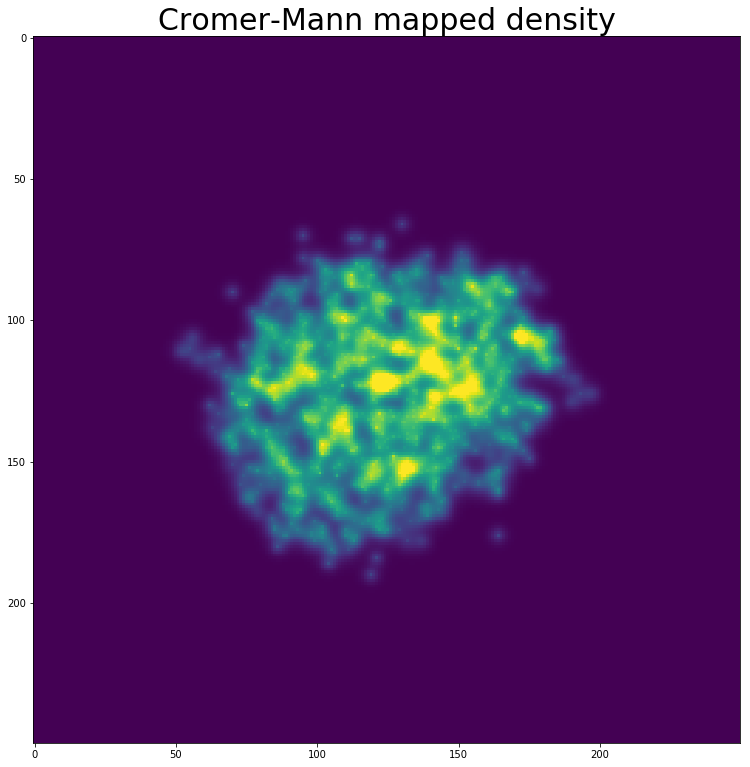

In [108]:
plt.figure(figsize=(13,13))
_=plt.title("Cromer-Mann mapped density", fontsize=30)
_=plt.imshow( dens.mean(0), vmax=2)


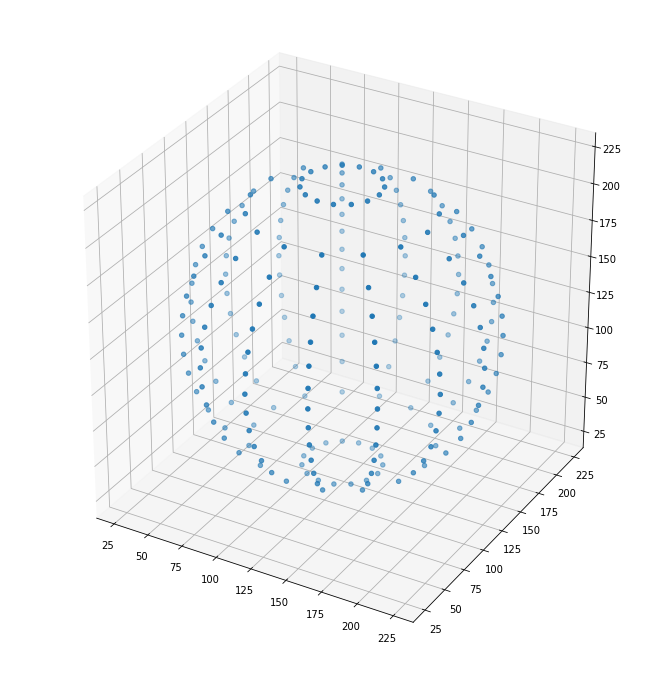

In [109]:
## similar to 2D case, we project along lines from center of protein and find
## finite density coordinates near the edge of each vector

# lets locate the center of the density
z,y,x = np.where( dens > 0)

# center of density
z_cent, y_cent, x_cent = z.mean(), y.mean(), x.mean()


Nphi = Ntheta = 15
phi_bin = np.linspace( 0,2*np.pi, Nphi+1) - np.pi
phis = phi_bin[1:]*.5 + phi_bin[:-1]*.5

theta_bin = np.array([ np.arccos(cth) for cth in np.linspace( -1, 1, Ntheta+1)])
thetas = theta_bin[1:]*.5 + theta_bin[:-1]*.5

phis, thetas = map( np.array, zip( *[[i,j] for i in phis for j in thetas] ))

vecsX = x_cent + 100*np.sin(thetas)*np.cos(phis)
vecsY = y_cent+ 100*np.sin(thetas)*np.sin(phis)
vecsZ = z_cent + 100*np.cos(thetas)

vecs = np.array(zip(vecsX,vecsY,vecsZ))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter( *vecs.T)

In [110]:
# Determine PHI and Radius of each non-zero density

Z,Y,X = np.indices( dens.shape)
R = np.sqrt( (Z-z_cent)**2 + (Y-y_cent)**2 + (X-x_cent)**2) .ravel()
PHI = np.arctan2(Y-y_cent, X-x_cent ).ravel()
THETA = np.arccos( (Z.ravel()-z_cent) / R)

In [111]:
has_density = dens.ravel() > 0
PHI2 = PHI[has_density]
THETA2 = THETA[has_density]

In [112]:

solvent_shell_thickness = 6 # from jochen hub paper
phi_spacing = (phi_bin[1] - phi_bin[0] ) *0.3
theta_spacing = (theta_bin[0] - theta_bin[1])*.3
print phi_spacing, theta_spacing

0.12566370614359176 0.15669444654181447


In [115]:

print (np.sum( has_density))

bounding_coors = []
bounding_coors0 = []



for phi,theta in zip( phis, thetas):
    phi1 = phi - phi_spacing*.5
    phi2 = phi + phi_spacing*.5
    close_to_phi = np.logical_and( PHI > phi1, PHI < phi2)
    
    theta1 = theta-theta_spacing*.5
    theta2 = theta+theta_spacing*.5
    close_to_theta = np.logical_and( THETA > theta1, THETA< theta2)
    
    
    valid_pt = np.logical_and(close_to_phi, close_to_theta)
    valid_pt = np.logical_and(  valid_pt, has_density) 
    
    idx_of_pt = np.where( valid_pt)[0]
    if not idx_of_pt.size:
        continue
    #assert( idx_of_pt.size)
    
    r_of_pt = R[idx_of_pt]
    
    rmax_loc =  idx_of_pt[ np.argmax( r_of_pt) ]
    
    #coor = np.unravel_index( rmax_loc, dens2.shape)
    
    theta_bound = theta
    phi_bound = phi #PHI[rmax_loc]
    R_bound = R[rmax_loc] + solvent_shell_thickness
    
    coorX = np.sin(theta) * np.cos( phi_bound)*R_bound + x_cent
    coorY = np.sin(theta) * np.sin( phi_bound)*R_bound + y_cent
    coorZ = np.cos(theta)*R_bound + z_cent
    coor = coorZ, coorY, coorX
    
    coorX0 = np.sin(theta)*np.cos( phi_bound)*R[rmax_loc] + x_cent
    coorY0 = np.sin(theta)*np.sin( phi_bound)*R[rmax_loc] + y_cent
    coorZ0 = np.cos(theta)*R[rmax_loc] + z_cent
    coor0 = coorZ0, coorY0, coorX0
    
    bounding_coors.append( coor)
    bounding_coors0.append( coor0)
    

1276013


In [116]:
pts = np.array( zip(Z.ravel(), Y.ravel(), X.ravel() ) )

In [117]:
from scipy.spatial import Delaunay
Del0 = Delaunay( bounding_coors0)
Del = Delaunay( bounding_coors)

In [118]:
in_path0 = Del0.find_simplex( pts) >=0
in_path = Del.find_simplex(pts)>=0

is_solvent = ~in_path
is_solvent_shell = np.logical_and( in_path, ~in_path0)



In [119]:
is_solvent3d = is_solvent.reshape( dens.shape)
is_solvent_shell_3d = is_solvent_shell.reshape( dens.shape)

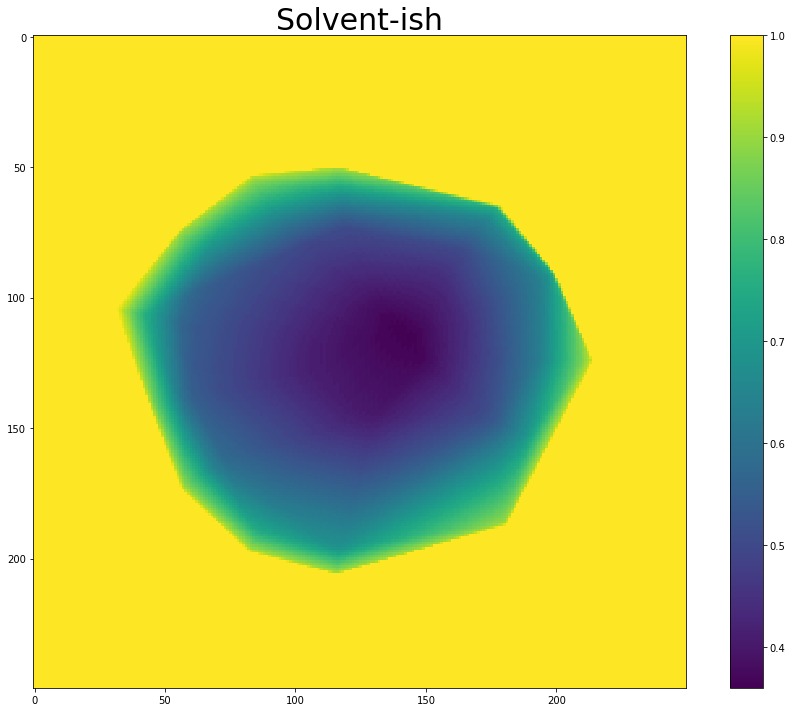

In [146]:
plt.figure(figsize=(16,12))
plt.imshow( np.mean(is_solvent3d,0))
plt.colorbar()
_=plt.title("Solvent-ish", fontsize=30)

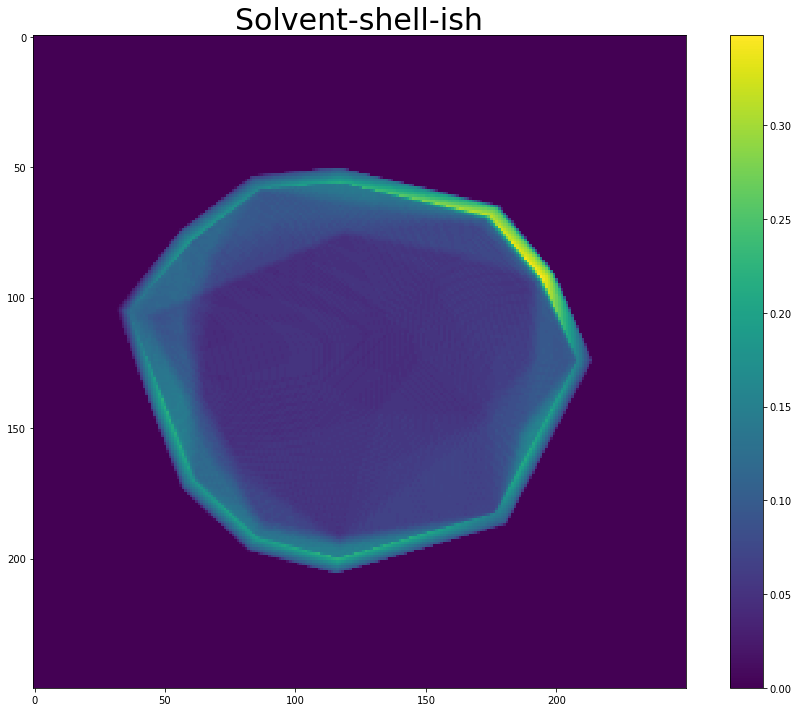

In [147]:
plt.figure(figsize=(16,12))
plt.imshow( np.mean(is_solvent_shell_3d,0))
plt.colorbar()
_=plt.title("Solvent-shell-ish", fontsize=30)

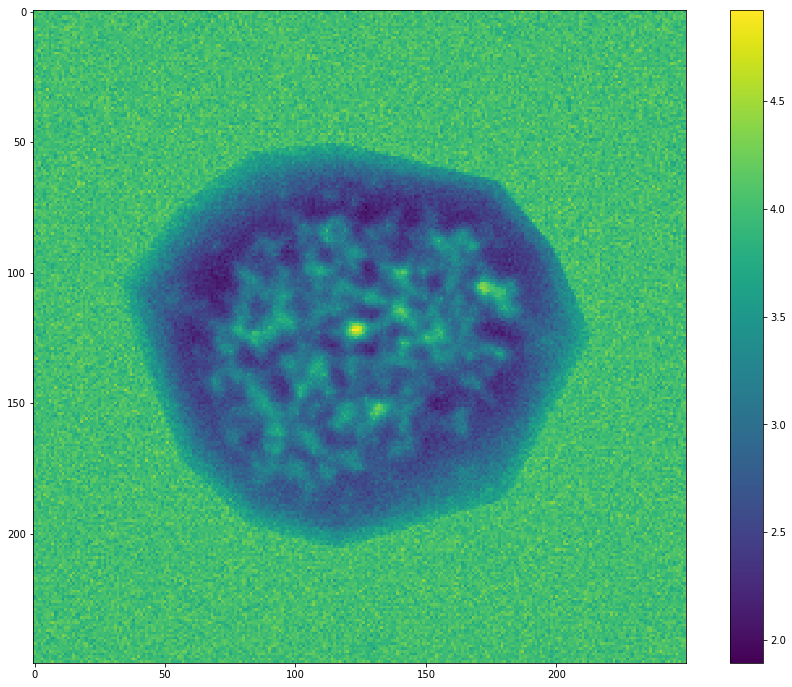

In [151]:
dens[is_solvend_shell_3d] = np.random.normal( 1, .01, np.sum(is_solvend_shell_3d))
dens[is_solvent3d] = np.random.normal( 4, 2, np.sum(is_solvent3d) )
plt.figure(figsize=(16,12))
plt.imshow( dens.mean(0))
_=plt.colorbar()